In [1]:
import nbpresent
nbpresent.__version__

'3.0.2'

# Setup everything

### Do imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# --- Import modules --- #
import numpy as np
import matplotlib.pyplot as plt

import os 
import os.path as op
import sys
import mne
from mne import pick_types, find_layout
from mne.io import read_info
from mne.viz import plot_topomap
from mne import stats as st
from custom_stats import *
from load_data import read_info_custom, LoadSczPowerData

### Setup parameters

In [3]:
# ---------- Setup stuff for plotting  ------------ #
# info_file = '/home/dmalt/Documents/Control/Control01/Control01_Closed.ds'  
# info needed to get sensors positions
# For .ds files info in a case of missing channel should 
# pick info_file with 271 meg channels, not 272


#                            | CHANGE THIS  |
#                           \/             \/
info_file = '/home/karim/Documents/Veronique/scripts/NEWPATIENT01_Open.ds' 
            #/home/dmalt/Dropbox/aut_gamma/K0001/K0001/K0001ec-epo.fif'
#                      /\   /\   /\   /\   /\   /\
#                      |    |    |    |    |    |
# ----------------------------------------------------------------------- #
    
info = read_info_custom(info_file)   # <-- works both with ctf and electa
layout = find_layout(info)           # <-- Get sensor positions. 

fsize = (16,7)
mask_params = dict(marker='*', markerfacecolor='m', markersize=10) # significant sensors appearence

In [4]:
# # ----------- ONLY FOR ELECTA (.fif) ------------- #

# # --- Setup indexing for different sensor types --- #
# # For ctf data this should be changed #
# grads1 = pick_types(info, meg='planar1')
# grads2 = pick_types(info, meg='planar2')
# mags   = pick_types(info, meg='mag')
# grads  = pick_types(info, meg='grad')

# ch_used = grads
# # ------------------------------------------------- #

In [5]:
# -------- IF THE DATA ARE CTF (.ds) EXECUTE THIS -------- #
ch_used = pick_types(info, meg=True, ref_meg=False, eeg=False) # use only axial gradiometers
if ch_used.shape[0] != 271:
    print 'WARNING: in case of "missing channel" ch_used.shape should be (271,), not {}'.format(ch_used.shape)

Channels missing in 271 set compared to 275 layout: ['MLT32' 'MLT36' 'MRO41' 'MRT36']
Their indices in 275-layout: [112, 116, 201, 248]


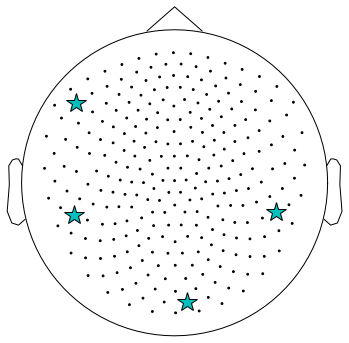

In [6]:
# ----------------- Setup sensor positions ------------------------ # 
# This cell should work both for ctf and electa data

#  Pick between ds and fif options for ch_names_info initialization
ch_names_info = [ch_name[:-5] for ch_name in info['ch_names']] # for .ds data; remove "-3305" postfix in ch_names
# ch_names_info = [ch_name for ch_name in info['ch_names']] # for .fif datafind_layout?

ch = np.ma.MaskedArray(ch_names_info, mask=True)
ch.mask[ch_used] = False # mark false for valid data, true for bads

# Create a masked array of ch_names for a standard layout masking out 
# names that are missing in info
ch_names_ma = np.ma.MaskedArray(layout.names, mask=[c not in ch[~ch.mask] for c in layout.names])
sensors_pos = layout.pos[~ch_names_ma.mask] # positions for sensors present in the data

print 'Channels missing in 271 set compared to 275 layout:', ch_names_ma.data[ch_names_ma.mask]
print 'Their indices in 275-layout:', [i for i in xrange(len(ch_names_ma.mask)) if ch_names_ma.mask[i]]

# Plot missing channels
rand_data = np.ones(275)
sen_all = layout.pos
mask_miss = ch_names_ma.mask
fig=plt.figure(figsize=(6,6))
# mask_miss[248] = False
m_params_miss = dict(marker='*', markerfacecolor='c', markersize=20) # significant sensors appearence
a, c = plot_topomap(rand_data, sen_all, cmap='gray',contours=None, mask=mask_miss, mask_params=m_params_miss)

In [7]:
# ----- Figure out which channel is missing (usually 245). For scz ctf dataset ----- #

# pick two info files - one with a complete set of 272 meg channels
# and the other with missing channel 
info_compl_fname = '/home/karim/Documents/Veronique/scripts/Control14_Closed.ds'
info_miss_fname = '/home/karim/Documents/Veronique/scripts/Control12_Closed.ds'

# # read info files
info_compl = read_info_custom(info_compl_fname)
info_miss = read_info_custom(info_miss_fname)

miss_ch_name = [ch_name for ch_name in info_compl['ch_names'] if ch_name not in info_miss['ch_names']][0]
miss_ch_id = list(np.array(info_compl['ch_names'])[ch_used]).index(miss_ch_name)

print 'Missing channel name: ' + miss_ch_name
print 'Missing channel number (relative to 272-channels set): ', miss_ch_id, '(0-based)'

Missing channel name: MRT36-3305
Missing channel number (relative to 272-channels set):  245 (0-based)


In [8]:
# In case we don't have info files
# miss_ch_id = 245 

# Interesting stuff starts here

### Load data 

In [9]:
# --------------- LOAD DATA --------------------- #
# This cell is dataset-specific.
# Load data for power statistical analysis for scz ctf dataset
# can be changed to plot connectivity. 
# Define paths to two folders which 
# contain data for two conditions we want to compare and load the data

# PREDEFINE:
# miss_ch_id       - missing channel 
# LoadSczPowerData - data loading function

# --------------------------------------------------------------- #
conds = ('Closed', 'Open')
bands = ('delta', 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma')

# Define subject names in the dataset
group_size = {'Controls': 28, 'Patients': 26}

subj_names = dict()
for grname in group_size.keys():
    l = [grname[:-1] + str(num + 1) for num in xrange(group_size[grname])]
    # Do 'Control1 --> Control01' replacement for all subjects
    subj_names[grname] = map(lambda s: s[:-1] + '0' + s[-1] if s[-2].isalpha() else s, l) 

print subj_names['Controls']
print subj_names['Patients']

# Mask out bad subjects

# init good_subjects mask with 

        
# List of bad subjects here        
bad_subjects = dict()
bad_subjects['Closed'] = ['Patient26', 'Patient05', 'Patient08']
bad_subjects['Open'] = ['Control24', 'Control11', 'Patient05', 'Patient08', 'Patient26']

# --------------------------------------------------------------- #
basedir = '/home/karim/Documents/Veronique/power_pipeline_output/'

data = dict()
fnames = dict()

# ----------- Load all the data ------------ #
for cond in conds:
    data[cond] = dict()
    fnames[cond] = dict()    
    for band in bands:
        data[cond][band] = dict()
        fnames[cond][band] = dict()
        for group in subj_names.keys():
            subdir = group + '_' + cond
            cond_dir = op.join(basedir, subdir, group + '_' + cond + '_' + band)
            
            cond_data, cond_fnames = LoadSczPowerData(cond_dir, subj_names[group], miss_ch_id)
            
            #  ---- Mask bad subjects ---- #
            bads_mask = np.array([subj_name in bad_subjects[cond] for subj_name in subj_names[group]])
            cond_data.mask[bads_mask,:] = True
            cond_fnames.mask[bads_mask] = True
            
            data[cond][band][group]  = cond_data
            fnames[cond][band][group] = cond_fnames
            
# ----------------------------------------- #
# print fnames['Closed']['alpha']['Controls']
# cond1_data = data['-------Closed']['alpha'][]

['Control01', 'Control02', 'Control03', 'Control04', 'Control05', 'Control06', 'Control07', 'Control08', 'Control09', 'Control10', 'Control11', 'Control12', 'Control13', 'Control14', 'Control15', 'Control16', 'Control17', 'Control18', 'Control19', 'Control20', 'Control21', 'Control22', 'Control23', 'Control24', 'Control25', 'Control26', 'Control27', 'Control28']
['Patient01', 'Patient02', 'Patient03', 'Patient04', 'Patient05', 'Patient06', 'Patient07', 'Patient08', 'Patient09', 'Patient10', 'Patient11', 'Patient12', 'Patient13', 'Patient14', 'Patient15', 'Patient16', 'Patient17', 'Patient18', 'Patient19', 'Patient20', 'Patient21', 'Patient22', 'Patient23', 'Patient24', 'Patient25', 'Patient26']


In [10]:
def rm_masked(masked_data):
    return masked_data.data[~np.all(masked_data.mask, axis=1),:]

In [46]:
cond = 'Open'
band = 'highgamma'


cond1_data =  rm_masked(data[cond][band]['Controls'])
fnames1 = fnames[cond][band]['Controls'].compressed()

cond2_data = rm_masked(data[cond][band]['Patients'])
fnames2 = fnames[cond][band]['Patients'].compressed()
# fnames1.shape

In [48]:
# Do normalization

# No normalization
cond1_data_norm = cond1_data
cond2_data_norm = cond2_data

# By mean
# cond1_data_norm = cond1_data / cond1_data.mean(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.mean(axis=1)[:,None]

# By max
# cond1_data_norm = cond1_data / cond1_data.max(axis=1)[:,None]
# cond2_data_norm = cond2_data / cond2_data.max(axis=1)[:,None]

# Z-scores
# cond1_data_norm = (cond1_data - cond1_data.mean(axis=1)[:,None]) / cond1_data.std(axis=1)[:,None]
# cond2_data_norm = (cond2_data - cond2_data.mean(axis=1)[:,None]) / cond2_data.std(axis=1)[:,None]

In [43]:
# ----- statistical mask setup --------- #
thresh = 0.01
# thresh = 0.001

# stat_test_func = fdr(no_corr_mannwhitneyu)
# stat_test_func = fdr(unpair_no_corr_t_test)
# stat_test_func = unpair_no_corr_t_test
# stat_test_func = unpair_clust_f_test
stat_test_func = fdr(unpair_no_corr_perm_t_test)

mask, p_vals = GetStatMask(cond1_data_norm, cond2_data_norm, stat_test_func=stat_test_func, p_thresh=thresh)
print 'Indices of significant sensors:', [i for i in xrange(len(p_vals)) if p_vals[i] < thresh]
# p_vals

Indices of significant sensors: [2, 8, 9, 13, 18, 19, 20, 22, 27, 44, 57, 58, 59, 61, 62, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 103, 109, 111, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 180, 187, 188, 191, 192, 210, 215, 216, 220, 221, 222, 223, 246, 254, 266, 267, 270]


CONDITION: Open, BAND: lowgamma


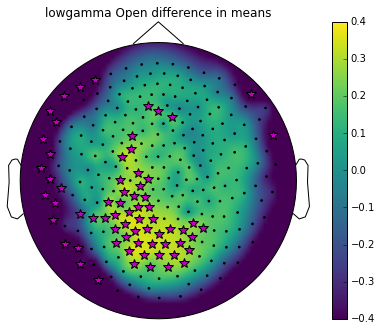

In [44]:
# Plot mean difference and the variance of this difference between groups
print 'CONDITION: {}, BAND: {}'.format(cond, band)

# Relative change in mean:
data_mean = np.divide(cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0), cond1_data_norm.mean(axis=0)) 
# data_mean = cond1_data_norm.mean(axis=0) - cond2_data_norm.mean(axis=0)
fig = plt.figure(figsize=(8,5))

# Plot diff of means
ax,_ = plot_topomap(data_mean, sensors_pos, mask=mask, mask_params=mask_params,
                    cmap='viridis', show=False, vmin=-0.4, vmax=0.4, contours=0)
plt.title(band + ' ' + cond + ' ' + 'difference in means')
fig.colorbar(ax)#, shrink=0.2)

plt.show()
plt.close(fig)

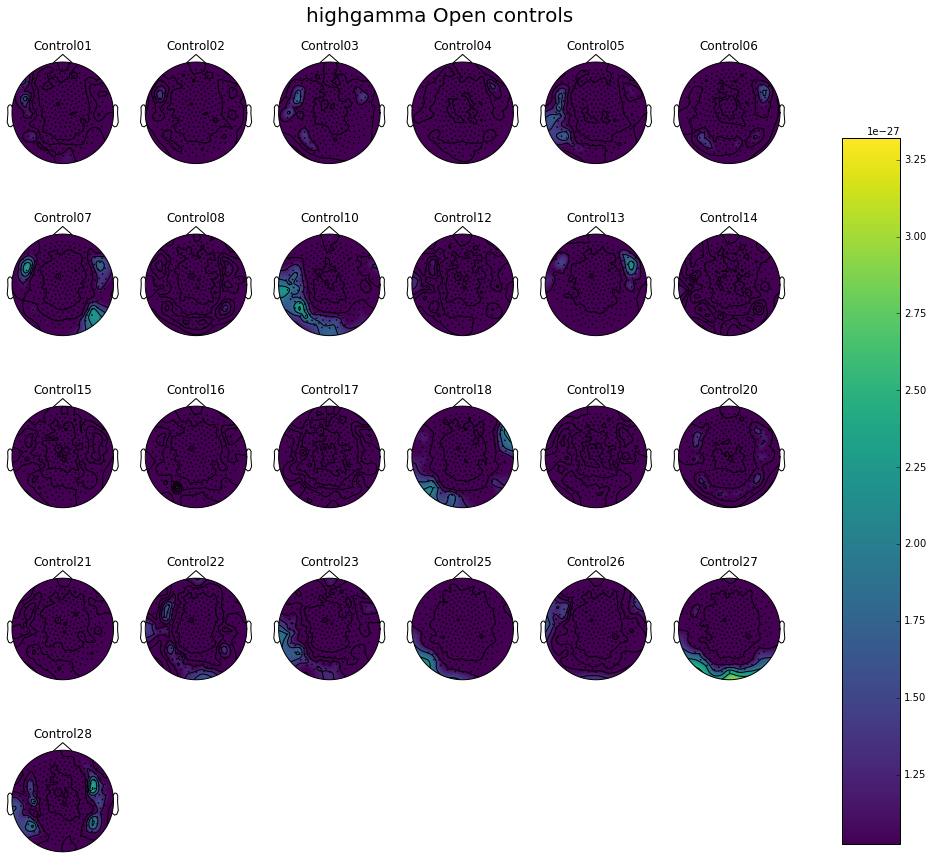

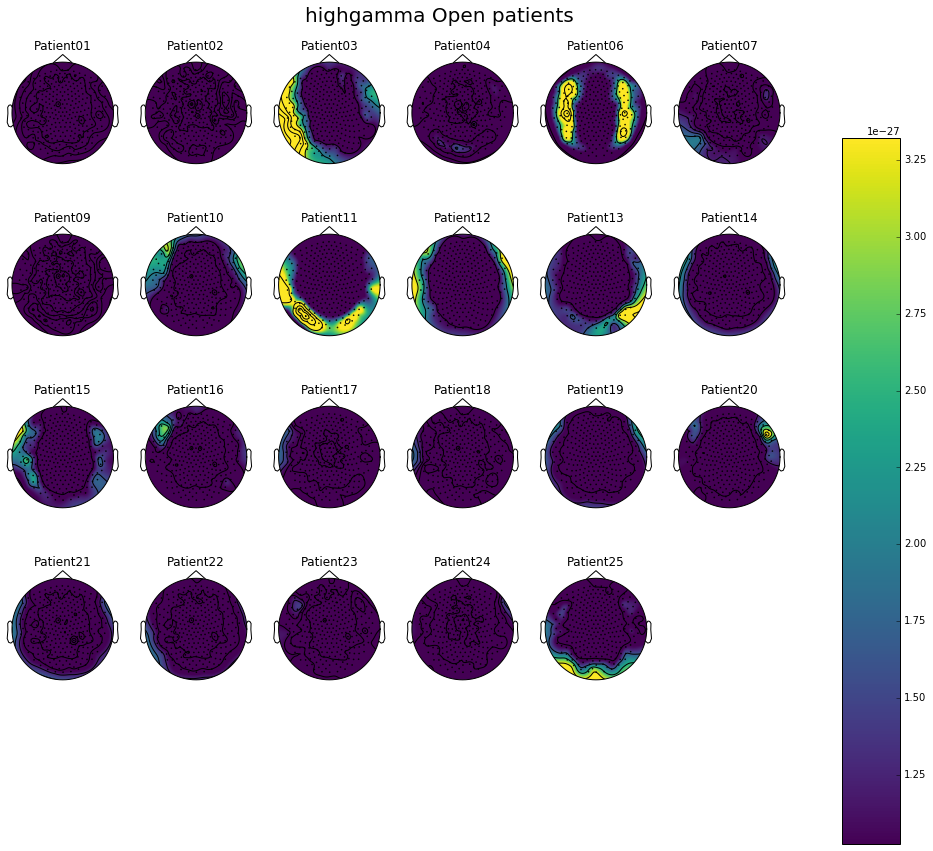

In [49]:
# Plot all cond
vmin = min(cond1_data_norm.min(), cond2_data_norm.min()) * 5
vmax = max(cond1_data_norm.max(), cond2_data_norm.max()) / 5


for cond_data_norm,  fn, group in zip((cond1_data_norm, cond2_data_norm), (fnames1, fnames2), ('controls', 'patients')):
    n_iter = cond_data_norm.shape[0]
    subj_names = map(lambda s: s[:9], fn)
    fig = plt.figure(figsize=(14,14))
    # fig, axes = plt.subplots(nrows=25, ncols=25, sharex=True, sharey=True)
    fig.set_size_inches(16,14)

    for i in range(n_iter):
        plt.subplot(5,6,i + 1)
        ax = plt.gca()
        data_i = cond_data_norm[i,:]
        im,_ = plot_topomap(data_i, sensors_pos, cmap='viridis', show=False, vmin=vmin, vmax=vmax)
        title = subj_names[i]
        plt.title(title)
    main_title = band + ' ' + cond + ' ' + group 
    plt.suptitle(main_title, fontsize=20)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()
    plt.close(fig) 